# Construyendo el primer modelo predictivo (Clasificación)

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2025  
**Versión:** 1.0  
  
**Fecha de actualización:** Enero de 2026  
**Versión:** 1.1

---

## Descripción

Este notebook muestra la construcción del primer modelo predictivo de una variable discreta, es decir, un `modelo de clasificación`.

El algoritmo usado es `Regresión logísitica`

Se automatizan la fases de preparación y modelado a través del uso de `pipeline de scikit-learn`

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (2.2.2)
- numpy (2.0.2)
- sklearn (1.6.1)
- matplotlib (3.10.0)

Para verificar si está instalado pandas, numpy o matplotlib ejecutar:

```bash
pip show pandas
```

```bash
pip show numpy
```

Para verificar las versiones, ejecutar:

```python
import sklearn
import matplotlib

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
```

# Conceptos previos

**¿Qué es la `Regresión Logística`?**

Es un modelo que predice probabilidades para decidir entre dos posibles resultados (por ejemplo: aprobar o no aprobar, comprar o no comprar, enfermo o sano).

En lugar de intentar “dibujar una línea recta” como en la regresión lineal, la regresión logística aprende una curva en forma de S (llamada sigmoide) que convierte cualquier número en una probabilidad entre 0 y 1.

En términos simples: *La regresión logística aprende qué combinación de variables hace más probable que algo ocurra o no ocurra*

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

# Clasificación binaria

## Generación de conjunto de datos

In [4]:
# Crear un dataset simple (simulado)
np.random.seed(29)
n = 100
horas_estudio = np.random.uniform(1, 10, n)
horas_sueno = np.random.uniform(4, 10, n)

# Variable dependiente: aprobar (1) o reprobar (0)
# Cuantas más horas estudie y duerma bien, mayor chance de aprobar
prob_aprob = 1 / (1 + np.exp(-(0.8*horas_estudio + 0.4*horas_sueno - 7)))
aprobado = np.random.binomial(1, prob_aprob)

data = pd.DataFrame({
    'Horas_estudio': horas_estudio,
    'Horas_sueno': horas_sueno,
    'Aprobado': aprobado
})

In [5]:
data.head()

,Horas_estudio,Horas_sueno,Aprobado
0,8.773840,9.994662,1
1,3.564154,8.401086,1
2,1.659307,8.530421,0
3,7.869135,7.321440,1
4,5.074472,7.472667,1


## Separación de variables

In [6]:
# Separar variables predictoras y objetivo
X = data[['Horas_estudio', 'Horas_sueno']]
y = data['Aprobado']

In [7]:
# Distribución de la variable objetivo
y.value_counts()

,count
Aprobado,
1,55
0,45


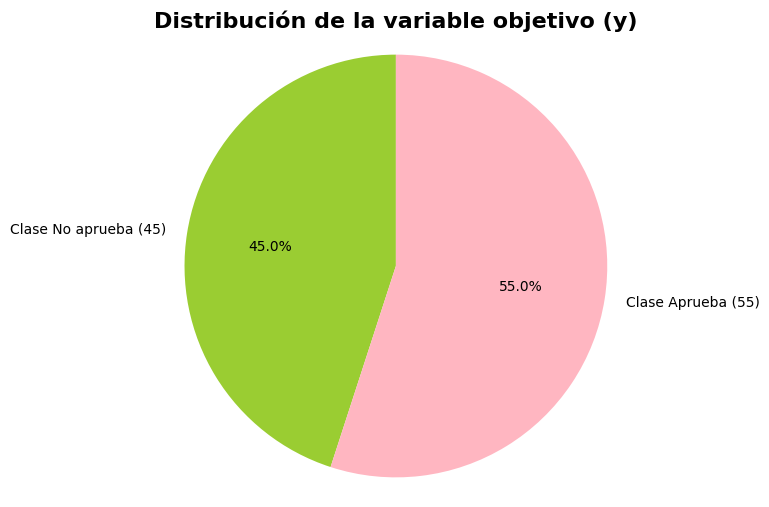

In [8]:
# Calcular proporciones por clase
clases, counts = np.unique(y, return_counts=True)
labels = [f"Clase {'No aprueba' if clases[i]==0 else 'Aprueba'} ({counts[i]})" for i in range(len(clases))]
colors = ["#9ACD32", "#FFB6C1"]

# Crear gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
plt.title("Distribución de la variable objetivo (y)", fontsize=16, fontweight="bold")
plt.axis("equal")
plt.show()

## Obtención de datos de entranemiento y prueba

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29,
                                                    stratify=y)

70% train y 30% test

75% train y 25% test

80% train y 20% test

## Creación del modelo

In [11]:
# Construir un pipeline: tratamiento atípicos + imputación + Escalado + Regresión Logística
modelo = Pipeline([
    ('winsorizer', Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

**✋¿Cómo quedaría el pipeline si se aplica para un problema multiclase?**

```python
modelo = Pipeline([
    ('winsorizer', Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),  
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='lbfgs'))
])
```

Donde:

`solver` es el algoritmo de optimización que se usa para ajustar los parámetros del modelo.

## Entrenamiento del modelo

In [12]:
# Entrenar el modelo
modelo.fit(X_train, y_train)

Pipeline(steps=[('windorizer', Winsorizer()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())])

## Evaluación del modelo

In [13]:
# Evaluar el modelo
y_pred = modelo.predict(X_test)

### Explicando la predicción

**Paso 1.** Calcula una combinación lineal de las variables (como la regresión lineal).
Ejemplo:

$z=b_0+b_1\times Horas_{estudio} + b_2\times Horas_{sueño}$

**Paso 2**. Pasa ese valor por una función sigmoide, que lo transforma en una probabilidad:

$P=\frac{1}{1+e^{-z}}$

**Paso 3**. Decide una clase según esa probabilidad:

Si $P ≥ 0.5 → Clase_1$

Si $P < 0.5 → Clase_0$


**¿La regresión logística es sólo para clasificación binaria?**

Nació como un modelo para clasificación binaria. Sin embargo, también se puede extener para problemas con dos o más clases.

**¿Cómo funciona en multiclase?**

+ Se puede usar una extensión de la regresión logística llamada **One-vs-Rest (OvR)**
+ Se pude usar **Softmax (o regresión logística multimodal)**

**One-vs-Rest (OvR)**

Se entrena una regresión logística por cada clase.

Cada modelo aprende a distinguir:

+ “¿Esta observación pertenece a mi clase o a cualquier otra?”

+ Luego, el modelo que asigne la mayor probabilidad gana.

Ejemplo: modelo que clasifica frutas: manzana, kiwi, naranja. Entonces se entrenan 3 modelos:

+ Manzana versus no manzana
+ Kiwi versus no kiwi
+ Naranja versus no naranja

La clase final es la que da la probabildiad más alta.

**Softmax (o regresión logística multimodal)**

+ Es una versión más elegante y simultánea del método anterior.

+ En lugar de varios modelos separados, usa una sola ecuación general que calcula una probabilidad para cada clase.

+ Estas probabilidades suman 1 (es decir, el modelo “reparte” la probabilidad entre todas las clases).

+ Se elige la clase con la mayor probabilidad.

Matemáticamente, usa la función *softmax*, que generaliza la sigmoide al caso multiclase.

### Cálculo de métricas

In [14]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No aprueba', 'Aprueba']))


Reporte de Clasificación:
              precision    recall  f1-score   support

  No aprueba       1.00      0.54      0.70        13
     Aprueba       0.74      1.00      0.85        17

    accuracy                           0.80        30
   macro avg       0.87      0.77      0.77        30
weighted avg       0.85      0.80      0.78        30



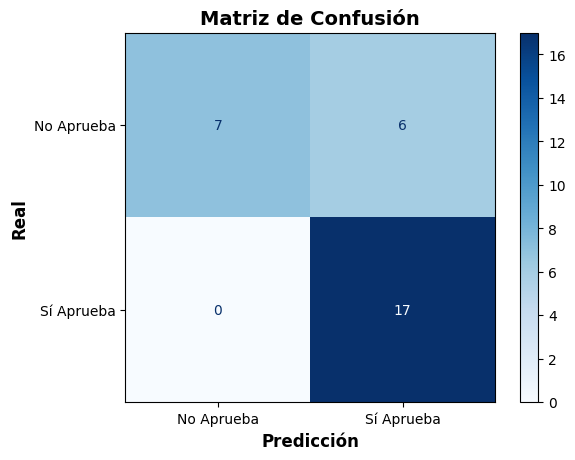

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=["No Aprueba", "Sí Aprueba"],
                                        cmap="Blues")
plt.title("Matriz de Confusión", fontsize=14, fontweight="bold")
plt.xlabel("Predicción", fontsize=12, fontweight="bold")
plt.ylabel("Real", fontsize=12, fontweight="bold")
plt.show()

### Frontera de decisión

La frontera de decisión es la línea (o superficie) que el modelo traza para separar las clases.

En el caso de la regresión logística, esta frontera representa el punto donde la probabilidad de pertenecer a una clase u otra es igual (50%).

Considere un modelo que intenta responder:

*“¿Con estas características, el estudiante aprobará o no?”*

La regresión logística calcula una probabilidad entre 0 y 1.

+ Si esa probabilidad es mayor o igual a 0.5, el modelo dice “Aprobará”.

+ Si es menor a 0.5, dice “No aprobará”.

El conjunto de puntos donde la probabilidad es igual a 0.5 forma la frontera de decisión. Es decir:

*Es el límite que separa las regiones del espacio donde el modelo predice clase 0 o clase 1.*

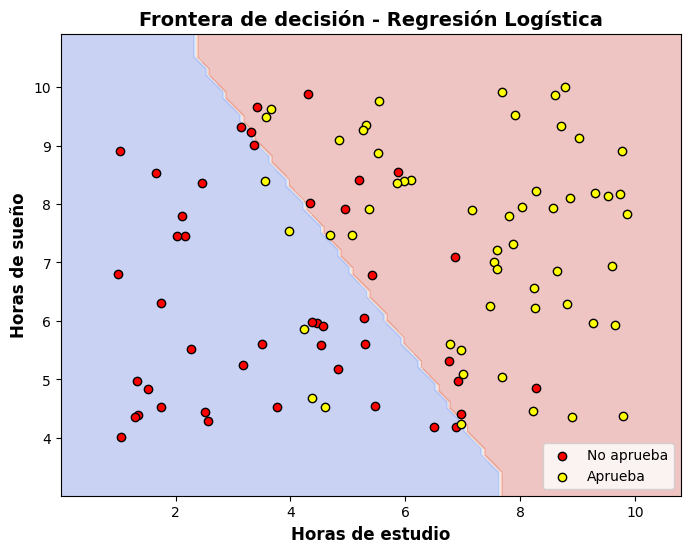

In [16]:
# Visualización (frontera de decisión)
x_min, x_max = X['Horas_estudio'].min()-1, X['Horas_estudio'].max()+1
y_min, y_max = X['Horas_sueno'].min()-1, X['Horas_sueno'].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Crear el DataFrame con nombres de columnas
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()],
                    columns=['Horas_estudio', 'Horas_sueno'])

Z = modelo.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
# Dibujar los puntos de datos con las etiquetas
for clase, color, label in zip([0,1], ['#FF0000','#FFFF00'],
                               ['No aprueba', 'Aprueba']):
    plt.scatter(
        X.loc[y==clase, 'Horas_estudio'],
        X.loc[y==clase, 'Horas_sueno'],
        c=color,
        edgecolors='k',
        label=label
    )
plt.xlabel('Horas de estudio', fontsize=12, fontweight="bold")
plt.ylabel('Horas de sueño', fontsize=12, fontweight="bold")
plt.title('Frontera de decisión - Regresión Logística', fontsize=14, fontweight="bold")
plt.legend(loc='lower right')
plt.show()


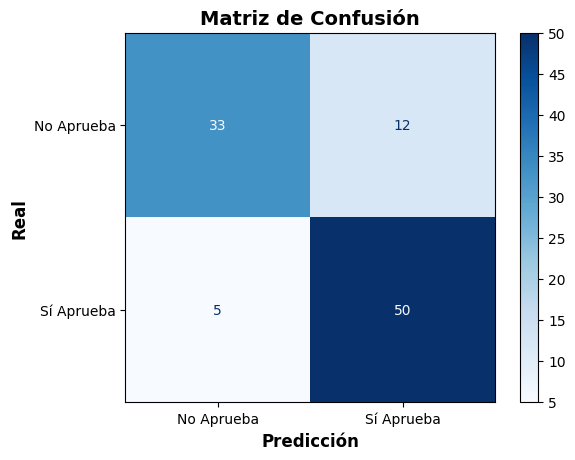

In [17]:
# Para comprobar lo anterior, observemos la matriz de confusión de la 'data completa'
ConfusionMatrixDisplay.from_predictions(y, modelo.predict(X),
                                        display_labels=["No Aprueba", "Sí Aprueba"],
                                        cmap="Blues")
plt.title("Matriz de Confusión", fontsize=14, fontweight="bold")
plt.xlabel("Predicción", fontsize=12, fontweight="bold")
plt.ylabel("Real", fontsize=12, fontweight="bold")
plt.show()

**✅ Interpretación**

A la izquierda de la frontera (poca dedicación o mal descanso) -> el modelo predice “No aprueba”.

A la derecha de la frontera (más estudio y mejor descanso) -> el modelo predice “Aprueba”.

En el gráfico, esa frontera aparece como una línea diagonal (puede ser curva si el modelo es más complejo).

Esa línea divide el plano en dos zonas con diferentes etiquetas predichas.

En definitiva, en este caso:

+ *“La frontera de decisión es el límite invisible que el modelo aprende para distinguir entre una clase y otra. En nuestro caso, **divide los estudiantes que probablemente aprueben de los que probablemente no lo hagan.**
Todo lo que quede a un lado de la línea será clasificado como 0, y al otro lado como 1.”*

# Clasificación multiclase

## Creación de conjunto de datos artificial

In [18]:
np.random.seed(29)
n = 200

horas_estudio = np.random.uniform(1, 10, n).round(1)
horas_sueno = np.random.uniform(4, 10, n).round(1)

# Genera una variable continua que combine ambas
nivel = 0.8*horas_estudio + 0.5*horas_sueno + np.random.normal(0, 1, n)

# Se definen 3 clases según rangos de "nivel"
# 0 = bajo, 1 = medio, 2 = alto
desempeno = np.digitize(nivel, bins=[8, 12])
data = pd.DataFrame({
    'Horas_estudio': horas_estudio,
    'Horas_sueno': horas_sueno,
    'Desempeno': desempeno
})

In [19]:
data.head()

,Horas_estudio,Horas_sueno,Desempeno
0,8.8,5.8,1
1,3.6,9.8,0
2,1.7,5.7,0
3,7.9,7.6,1
4,5.1,6.7,0


## Separación de variables

In [20]:
X = data[['Horas_estudio', 'Horas_sueno']]
y = data['Desempeno']

In [21]:
# Distribución de la variable objetivo
y.value_counts()

,count
Desempeno,
0,107
1,86
2,7


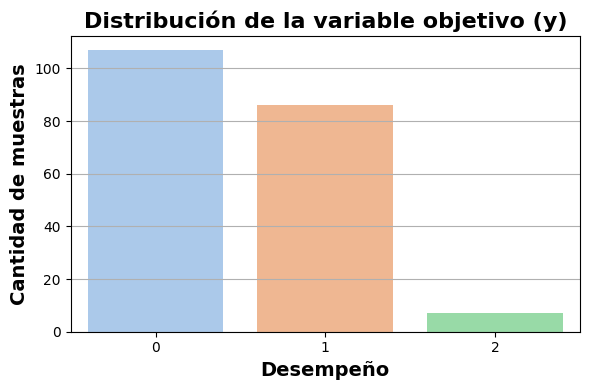

In [23]:
# Crear un DataFrame para graficar
data_y = pd.DataFrame(y, columns=["Desempeno"])

# Contar ocurrencias y graficar
plt.figure(figsize=(6, 4))
sb.countplot(data=data_y, x="Desempeno", hue = "Desempeno", palette="pastel", legend=False)
plt.title("Distribución de la variable objetivo (y)", fontsize=16, fontweight="bold")
plt.xlabel("Desempeño", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de muestras", fontsize=14, fontweight="bold")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Obtención de datos de entrenamiento y prueba

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29,
                                                    stratify=y)

## Creación del modelo

In [25]:
# Crear pipeline con regresión logística multinomial
modelo_mc = Pipeline([
    ('winsorizer', Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='lbfgs'))
])

## Entrena el modelo

In [26]:
modelo_mc.fit(X_train, y_train)

Pipeline(steps=[('winsorizer', Winsorizer()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())])

## Evaluación del modelo

In [27]:
y_pred = modelo_mc.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Bajo', 'Medio', 'Alto'],
                            zero_division=0))


Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.90      0.88      0.89        32
       Medio       0.79      0.88      0.84        26
        Alto       0.00      0.00      0.00         2

    accuracy                           0.85        60
   macro avg       0.57      0.59      0.58        60
weighted avg       0.83      0.85      0.84        60



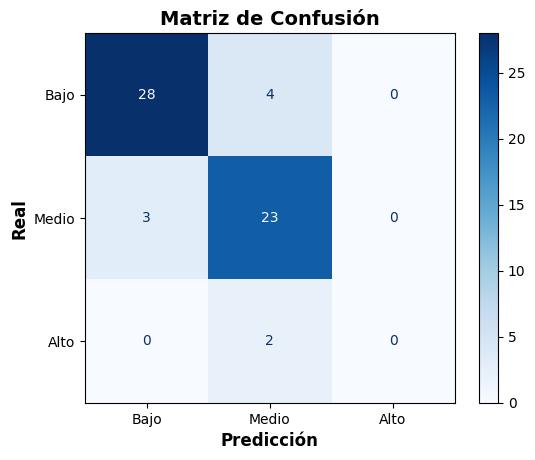

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=["Bajo", "Medio", "Alto"],
                                        cmap="Blues")
plt.title("Matriz de Confusión", fontsize=14, fontweight="bold")
plt.xlabel("Predicción", fontsize=12, fontweight="bold")
plt.ylabel("Real", fontsize=12, fontweight="bold")
plt.show()